<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot basado en reglas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [1]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pepiline nlp transformers
!pip install -U spacy==3.4.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.3 MB 5.0 MB/s 
     |████████████████████████████████| 11.1 MB 34.1 MB/s 
     |████████████████████████████████| 342 kB 5.2 MB/s 


In [2]:
import json
import string
import random 
import numpy as np
import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [3]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [4]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):    
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    #pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    #text = re.sub(pattern, '', text)
    #pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    pattern = r'[^a-z0-9.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [5]:
text = "personas Ideas! estás cosas 12 y los_? peces. y los mUrciélagos 33 ñañp"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas 12 y los peces y los murcielagos 33 nanp'

In [6]:
# Ejemplo de como fuciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokes = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokes)
print("Lematización de cada token:")
for token in tokes:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [27]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola", "¿Cómo estás?", "¿Qué tal?", "Buenas","hi"],
              "responses": ["Hola!", "Hola amig@", "Buenos dias" ]
             },
             {"tag": "nombre",
              "patterns": ["¿Cúal es tu nombre?", "¿Quién sos?", "¿Donde estoy?"],
              "responses": ["Estacionamiento Centro, a su servicio", "Estacionamiento Centro"]
             },
              {"tag": "lugar",
              "patterns": ["lugar", "¿Adonde voy?", "¿Hay lugar?", "¿Hay lugar en la playa?", "¿Donde estaciono?", "¿Número de lugar?", "¿Por donde voy?", "¿Por donde me meto?"],
              "responses": ["Siga la flecha y su zona es <numero>", "Su estacionamiento será <numero>", "Estacionamiento asignado <numero>", "Siga las indicaciones, su número es <numero> de estacionamiento"]
             },
            {"tag": "tiempo",
              "patterns": ["tiempo", "¿Cuanto es el tiempo maximo?", "¿Hasta que hora están?", "¿A que hora cierran?", "¿A que hora abren?"],
              "responses": ["Estamos abiertos de 8hs a 22hs", "Horario corrido de 8hs a 22hs"]
             },
             {"tag": "fraccion",
              "patterns": ["se fracciona la hora", "¿Cuanto es el tiempo minimo?", "¿la fraccion?","¿Cúal es el tiempo minimo?", "¿Puedo estar menos de la hora?"],
              "responses": ["Fraccion de 15min luego de 2 horas", "2 horas, luego se fracciona en 15 min"]
             },
            {"tag": "clima",
              "patterns": ["¿como está el clima?", "¿como está el tiempo?", "¿tienen seguro?", "¿Que pasa si vandalizan el auto?","Estoy en un lugar seguro"],
              "responses": ["Tenemos seguro", "Playa techada y segura", "Seguridad 24hs", "Siga las novedades con el <link>", "Lugar iluminado y seguro"]
             },
            {"tag": "precios",
              "patterns": ["precio", "Me podrás pasar los precios por hora", "¿Cuánto vale?", "¿Cuánto sale?", "¿Cuanto pago?"],
              "responses": ["Precio por hora es $100"]
             },
            {"tag": "pagos",
              "patterns": ["medios de pago", "tarjeta de crédito", "tarjetas", "cuotas", "Se ¿puede pagar efectivo?","que medios aceptan de pago", "¿Donde hago el pago?"],
              "responses": ["A la salida podrá pagar por distintos medios", "Pagos a la salida", "Aceptamos distintos pagos"]
             },
             {"tag": "salida",
              "patterns": ["Por donde salgo", "¿Donde está la salida?", "salida", "¿Por donde me retiro?", "Como salgo", "Por donde voy"],
              "responses": ["A la salida podrá pagar por distintos medios, siga las indicaciones", "Atento a las flechas de salida", "Siga las señales de indicación"]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias"],
              "responses": ["Por nada!, lo estaremos esperando"]
             },
             {"tag": "despedida",
              "patterns": [ "Chau", "Hasta luego!"],
              "responses": ["Hasta luego!", "Lo esperamos, en la proxima visita!"]
             }
]}

### 4 - Preprocesamiento y armado del dataset

In [28]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterízan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["tag"])
    
    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocubulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

In [30]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'abrir', 'aceptar', 'adonde', 'auto', 'buen', 'cerrar', 'chau', 'clima', 'como', 'credito', 'cual', 'cuanto', 'cuota', 'de', 'donde', 'e', 'efectivo', 'el', 'en', 'estacionar', 'estar', 'este', 'fraccion', 'fraccionar', 'gracias', 'haber', 'hacer', 'hasta', 'hi', 'holar', 'hora', 'ir', 'luego', 'lugar', 'maximo', 'medio', 'menos', 'meter', 'minimo', 'mucho', 'nombre', 'numero', 'pagar', 'pago', 'pasar', 'playa', 'poder', 'por', 'precio', 'que', 'quien', 'retiro', 'salida', 'salir', 'seguro', 'ser', 'si', 'tal', 'tarjeta', 'tener', 'tiempo', 'tu', 'uno', 'valer', 'vandalizar', 'yo', 'él']
classes: ['agradecimientos', 'bienvenida', 'clima', 'despedida', 'fraccion', 'lugar', 'nombre', 'pagos', 'precios', 'salida', 'tiempo']
doc_X: ['Hola', '¿Cómo estás?', '¿Qué tal?', 'Buenas', 'hi', '¿Cúal es tu nombre?', '¿Quién sos?', '¿Donde estoy?', 'lugar', '¿Adonde voy?', '¿Hay lugar?', '¿Hay lugar en la playa?', '¿Donde estaciono?', '¿Número de lugar?', '¿Por donde voy?', '¿Por donde 

In [31]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 68


In [32]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 11


In [33]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0

### 5 - Entrenamiento del modelo

In [34]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (68,) output: 11


In [35]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               8832      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 11)               

In [36]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
2/2 [==============================] - 1s 8ms/step - loss: 2.4332 - accuracy: 0.0943
Epoch 2/200
2/2 [==============================] - 0s 7ms/step - loss: 2.4608 - accuracy: 0.0566
Epoch 3/200
2/2 [==============================] - 0s 9ms/step - loss: 2.4286 - accuracy: 0.1509
Epoch 4/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3927 - accuracy: 0.1132
Epoch 5/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3809 - accuracy: 0.0566
Epoch 6/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3487 - accuracy: 0.1321
Epoch 7/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3697 - accuracy: 0.1321
Epoch 8/200
2/2 [==============================] - 0s 6ms/step - loss: 2.3516 - accuracy: 0.1698
Epoch 9/200
2/2 [==============================] - 0s 7ms/step - loss: 2.3702 - accuracy: 0.1321
Epoch 10/200
2/2 [==============================] - 0s 8ms/step - loss: 2.3740 - accuracy: 0.1698
Epoch 11/200
2/2 [===========

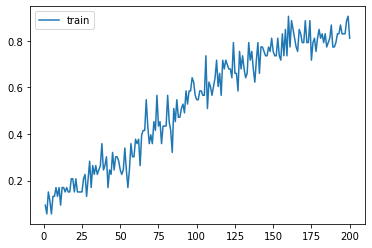

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [38]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

### 6 - Testing y validación

In [39]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada 
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents: 
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria 
            result = random.choice(i["responses"])
            break
    return result

### CHATBOT de Playa de Estacionamiento

In [41]:
while True:
    # pedir input al usuario
    message = input("")
    print("Q:", message)

    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else: # si no hubo ningún resultado que supere el umbral
        print("BOT: Perdón, no comprendo la pregunta.")
    

Buenas
Q: Buenas
1/1 [==============================] - 0s 17ms/step
BOT: Hola amig@
¿Donde me estaciono?
Q: ¿Donde me estaciono?
1/1 [==============================] - 0s 17ms/step
BOT: Siga las indicaciones, su número es <numero> de estacionamiento
Cuanto cuesta
Q: Cuanto cuesta
1/1 [==============================] - 0s 17ms/step
BOT: Precio por hora es $100
horarios?
Q: horarios?
BOT: Perdón, no comprendo la pregunta.
¿Cierran a la noche?
Q: ¿Cierran a la noche?
1/1 [==============================] - 0s 22ms/step
BOT: Horario corrido de 8hs a 22hs
Me voy ¿Donde pago?
Q: Me voy ¿Donde pago?
1/1 [==============================] - 0s 19ms/step
BOT: Su estacionamiento será <numero>
¿Adonde tengo que pagar?
Q: ¿Adonde tengo que pagar?
1/1 [==============================] - 0s 17ms/step
BOT: Estacionamiento asignado <numero>
¿Por donde me voy?
Q: ¿Por donde me voy?
1/1 [==============================] - 0s 18ms/step
BOT: Estacionamiento asignado <numero>
Quiero pagar 
Q: Quiero pagar 
1/1

KeyboardInterrupt: ignored

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

Interesante las opciones de respuestas, ya que el entrenamiento toma en cuenta las palabras claves. En esta situación en particular (Playa de estacionamiento) la conjunción entre IOT y IA puede llevar a automatizar la asignacion de lugares de acuerdo al tiempo estimado por los propios usuarios y/o el sistema aprendiendo el tiempo de acuerdo al dia de la semana. asignando lugares en el fondo y mas cerca de la salida a los que solo van por tiempos cor

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.